In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FixedLocator

from astropy import constants as const
import astropy.units as u

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, Matern, ConstantKernel, RBF

In [2]:
%matplotlib notebook

In [3]:
# meta data
z = 0.0094
tb_max = 58863.34
t_fl = -17.4928
mu = 33.14
dist = 42.5

# Bolometric Luminosity

We will estimate the bolometric luminosity by integrating the SED (using trapezoidal integration). The optical observations will be interpolated to the times of UV observations, which are far less frequent.

In [4]:
flux_obs = pd.read_csv('../plots/flux_obs_19yvq.csv')
flux_obs.head(5)

,t_restframe,flux_Jy,flux_unc_Jy,filt
0,0.779844,0.000505,0.000007,r
1,0.847793,0.000374,0.000005,i
2,0.867332,0.000595,0.000006,g
3,3.731084,0.000488,0.000008,r
4,3.789436,0.000379,0.000006,g


In [5]:
uvm2_lambda_eff = 2360
uvw1_lambda_eff = 3050
g_lambda_eff = 4722.74
r_lambda_eff = 6339.61
i_lambda_eff = 7886.13

In [6]:
nu_eff = const.c.to('Angstrom/s').value/np.array([1000,
                                                  uvm2_lambda_eff, 
                                                  uvw1_lambda_eff, 
                                                  g_lambda_eff, 
                                                  r_lambda_eff, 
                                                  i_lambda_eff, 
                                                  21590])

In [7]:
g_obs = np.where(flux_obs.filt == 'g')
r_obs = np.where(flux_obs.filt == 'r')
i_obs = np.where(flux_obs.filt == 'i')

uvw1_obs = np.where((flux_obs.filt == 'UVW1') & (flux_obs.t_restframe > 0))
uvm2_obs = np.where((flux_obs.filt == 'UVM2') & (flux_obs.t_restframe > 0))

X_uvm2 = np.atleast_2d(flux_obs.iloc[uvm2_obs].t_restframe).T
y_uvm2 = flux_obs.iloc[uvm2_obs].flux_Jy


X_uvw1 = np.atleast_2d(flux_obs.iloc[uvw1_obs].t_restframe).T
y_uvw1 = flux_obs.iloc[uvw1_obs].flux_Jy

X_g = np.atleast_2d(flux_obs.iloc[g_obs].t_restframe).T
y_g = flux_obs.iloc[g_obs].flux_Jy

X_r = np.atleast_2d(flux_obs.iloc[r_obs].t_restframe).T
y_r = flux_obs.iloc[r_obs].flux_Jy

X_i = np.atleast_2d(flux_obs.iloc[i_obs].t_restframe).T
y_i = flux_obs.iloc[i_obs].flux_Jy


kernel = ConstantKernel(1)*Matern(length_scale=25, length_scale_bounds=(1e-2,100)) 

gpr_uvm2 = GaussianProcessRegressor(kernel=kernel, 
                                    alpha=flux_obs.iloc[uvm2_obs].flux_unc_Jy.values**2, 
                                    n_restarts_optimizer=9).fit(X_uvm2, y_uvm2)

gpr_uvw1 = GaussianProcessRegressor(kernel=kernel, 
                                    alpha=flux_obs.iloc[uvw1_obs].flux_unc_Jy.values**2, 
                                    n_restarts_optimizer=9).fit(X_uvw1, y_uvw1)


gpr_g = GaussianProcessRegressor(kernel=kernel, 
                                 alpha=flux_obs.iloc[g_obs].flux_unc_Jy.values**2, 
                                 n_restarts_optimizer=9).fit(X_g, y_g)

gpr_r = GaussianProcessRegressor(kernel=kernel,
                                 alpha=flux_obs.iloc[r_obs].flux_unc_Jy.values**2, 
                                 n_restarts_optimizer=9).fit(X_r, y_r)


gpr_i = GaussianProcessRegressor(kernel=kernel,
                                 alpha=flux_obs.iloc[i_obs].flux_unc_Jy.values**2, 
                                 n_restarts_optimizer=9).fit(X_i, y_i)


/Users/adamamiller/miniconda3/envs/emcee3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:480: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([1.38428842e+00, 4.65088195e-04]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)


In [8]:
# K band to i band relative flux at 8500 K
temp = u.Kelvin*8500

i_bb = 1/(u.Angstrom*7886.13)**3*(1/(np.exp(const.h*const.c/(const.k_B*temp*(u.Angstrom*7886.13))) - 1))
J_bb = 1/(u.Angstrom*12350)**3*(1/(np.exp(const.h*const.c/(const.k_B*temp*(u.Angstrom*12350))) - 1))
H_bb = 1/(u.Angstrom*16620)**3*(1/(np.exp(const.h*const.c/(const.k_B*temp*(u.Angstrom*16620))) - 1))
K_bb = 1/(u.Angstrom*21590)**3*(1/(np.exp(const.h*const.c/(const.k_B*temp*(u.Angstrom*21590))) - 1))
bb_10 = 1/(u.Angstrom*100000)**3*(1/(np.exp(const.h*const.c/(const.k_B*temp*(u.Angstrom*100000))) - 1))

print(K_bb/i_bb)

full_curve = 1/(u.Angstrom*np.linspace(1e7,1e3,10000))**3*(1/(np.exp(const.h*const.c/(const.k_B*temp*(u.Angstrom*np.linspace(1e7,1e3,10000)))) - 1))

temp = u.Kelvin*12500
uvm2_bb = 1/(u.Angstrom*2360)**3*(1/(np.exp(const.h*const.c/(const.k_B*temp*(u.Angstrom*2360))) - 1))
bb_1000 = 1/(u.Angstrom*1000)**3*(1/(np.exp(const.h*const.c/(const.k_B*temp*(u.Angstrom*1000))) - 1))

print(bb_1000/uvm2_bb)

0.30929811261165874
0.017168826141433047


### Make predictions for the flux in each filter

In [9]:
t_grid = np.linspace(1,70,1381)

uvm2_pred, uvm2_unc = gpr_uvm2.predict(np.atleast_2d(t_grid).T, return_std=True)
uvw1_pred, uvw1_unc = gpr_uvw1.predict(np.atleast_2d(t_grid).T, return_std=True)
g_pred, g_unc = gpr_g.predict(np.atleast_2d(t_grid).T, return_std=True) 
r_pred, r_unc = gpr_r.predict(np.atleast_2d(t_grid).T, return_std=True) 
i_pred, i_unc = gpr_i.predict(np.atleast_2d(t_grid).T, return_std=True)

The flux in the UV is not detected by Swift in epochs with $t_\mathrm{fl} \gtrsim 26.5$ d. To account for this in the bolometric light curve, we fix the ratio of UV flux to the g-band in epochs > 26.5 d, while accounting for the uncertainties in the UV and optical at this phase. 

In [10]:
# fix ratio of UV/g-band flux -- 26.5 d is last good detection of Swift

freeze_uv = np.where(t_grid == 26.5)[0][0]
m2_to_g = uvm2_pred[freeze_uv]/g_pred[freeze_uv]
w1_to_g = uvw1_pred[freeze_uv]/g_pred[freeze_uv]

uvm2_fix = uvm2_pred.copy()
uvm2_fix_unc = uvm2_unc.copy()
uvm2_fix[freeze_uv:] = g_pred[freeze_uv:]*m2_to_g
uvm2_fix_unc[freeze_uv:] = uvm2_fix[freeze_uv:] * np.sqrt((g_unc[freeze_uv:]/g_pred[freeze_uv:])**2 + 
                                                          (uvm2_unc[freeze_uv]/uvm2_pred[freeze_uv])**2 + 
                                                          (g_unc[freeze_uv]/g_pred[freeze_uv])**2)
uvw1_fix = uvw1_pred.copy()
uvw1_fix_unc = uvw1_unc.copy()
uvw1_fix[freeze_uv:] = g_pred[freeze_uv:]*w1_to_g
uvw1_fix_unc[freeze_uv:] = uvw1_fix[freeze_uv:] * np.sqrt((g_unc[freeze_uv:]/g_pred[freeze_uv:])**2 + 
                                                          (uvw1_unc[freeze_uv]/uvw1_pred[freeze_uv])**2 + 
                                                          (g_unc[freeze_uv]/g_pred[freeze_uv])**2)

<IPython.core.display.Javascript object>


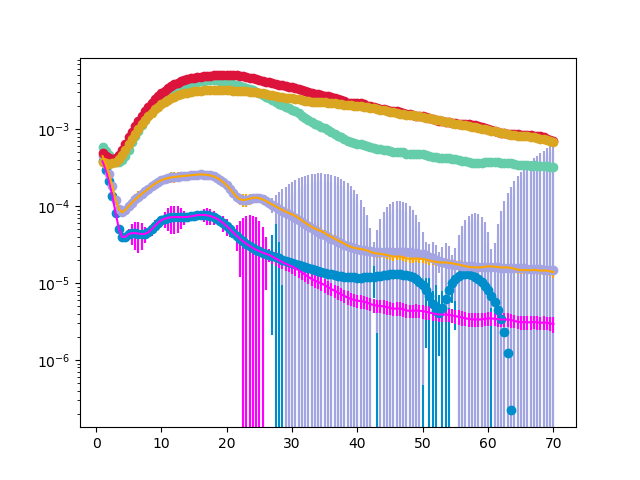

In [11]:
color_dict = {1: 'MediumAquaMarine',
              2: 'Crimson', 
              3: 'Goldenrod', 
              "uvw2": "#D71DE5",
              "uvm2": "#008DCB",
              "uvw1": "#A4A4E3"}

fig, ax = plt.subplots()
ax.errorbar(t_grid[::10], uvm2_pred[::10], uvm2_unc[::10], fmt='o', color=color_dict['uvm2'])
ax.errorbar(t_grid[::10], uvw1_pred[::10], uvw1_unc[::10], fmt='o', color=color_dict['uvw1'])
ax.errorbar(t_grid[::10], g_pred[::10], g_unc[::10], fmt='o', color=color_dict[1])
ax.errorbar(t_grid[::10], r_pred[::10], r_unc[::10], fmt='o', color=color_dict[2])
ax.errorbar(t_grid[::10], i_pred[::10], i_unc[::10], fmt='o', color=color_dict[3])
ax.errorbar(t_grid[::10], uvm2_fix[::10], uvm2_fix_unc[::10], color='magenta')

ax.errorbar(t_grid[::10], uvw1_fix[::10], uvw1_fix_unc[::10], color='orange')
ax.set_yscale('log')

In [12]:
obs_sed = np.array([uvm2_fix*bb_1000/uvm2_bb,
                    uvm2_fix,
                    uvw1_fix,
                    g_pred, 
                    r_pred, 
                    i_pred,
                    i_pred*K_bb/i_bb])

red_correction = 10**(0.4*np.array([0.4043,0.4043, 0.2745, 0.1877, 0.1240, 0.0876, 
                                    0.0876]))
true_sed = obs_sed.T*red_correction

In [13]:
flux2lum = 1e-23*4*np.pi*(42.5e6*const.pc.to('cm').value)**2

lum = np.trapz(np.flip(true_sed, axis=1), nu_eff[::-1]*(1+z)) * flux2lum

uvgri_lum = np.trapz(np.flip(true_sed[:,1:-1], axis=1), nu_eff[::-1][1:6]*(1+z)) * flux2lum

gri_lum = np.trapz(np.flip(true_sed[:,3:-1], axis=1), nu_eff[::-1][1:4]*(1+z)) * flux2lum
ir_lum = np.trapz(np.flip(true_sed[:,5:], axis=1), nu_eff[::-1][0:2]*(1+z)) * flux2lum
uv_lum = np.trapz(np.flip(true_sed[:,1:4], axis=1), nu_eff[::-1][3:6]*(1+z)) * flux2lum
uv_cor_lum = np.trapz(np.flip(true_sed[:,0:2], axis=1), nu_eff[::-1][5:7]*(1+z)) * flux2lum

<IPython.core.display.Javascript object>


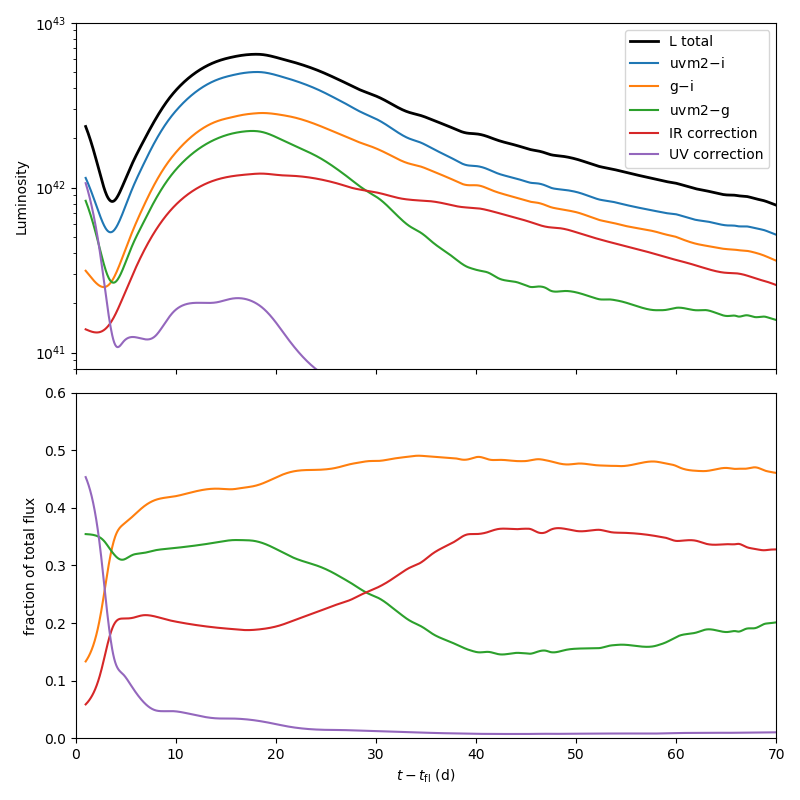

Lmax = 6.445e+42


In [14]:
fig, (ax, ax_frac) = plt.subplots(2,1, figsize=(8,8), sharex=True)

ax.plot(t_grid, lum, 'k', lw=2, label='L total')
ax.plot(t_grid, uvgri_lum, label=r'uvm2$-$i')
ax.plot(t_grid, gri_lum, label=r'g$-$i')
ax.plot(t_grid, uv_lum, label=r'uvm2$-$g')
ax.plot(t_grid, ir_lum, label=r'IR correction')
ax.plot(t_grid, uv_cor_lum, label=r'UV correction')
ax.set_yscale('log')
ax.set_ylim(8e40,1e43)
ax.set_ylabel('Luminosity')
ax.legend()

ax_frac.plot([1e6,1e6], [1e6,1e6])
ax_frac.plot(t_grid, gri_lum/lum)
ax_frac.plot(t_grid, uv_lum/lum)
ax_frac.plot(t_grid, ir_lum/lum)
ax_frac.plot(t_grid, uv_cor_lum/lum)
ax_frac.set_ylabel('fraction of total flux')
ax_frac.set_xlabel(r'$t - t_\mathrm{fl}$ (d)')
ax_frac.set_xlim(0,70)
ax_frac.set_ylim(0,0.6)
fig.tight_layout()

print('Lmax = {:.4}'.format(np.max(lum)))

In [15]:
lum_unc = np.zeros((len(lum), 2))
for idx in range(len(lum)):
    uvm2_rand = np.random.normal(uvm2_fix[idx], uvm2_fix_unc[idx], size=1000)
    uvw1_rand = np.random.normal(uvw1_fix[idx], uvw1_fix_unc[idx], size=1000)
    g_rand = np.random.normal(g_pred[idx], g_unc[idx], size=1000)
    r_rand = np.random.normal(r_pred[idx], r_unc[idx], size=1000)
    i_rand = np.random.normal(i_pred[idx], i_unc[idx], size=1000)
    
    uvm2_rand = np.clip(uvm2_rand, 0, 1e10)
    uvw1_rand = np.clip(uvw1_rand, 0, 1e10)
    
    rand_sed = np.vstack([uvm2_rand*bb_1000.value/uvm2_bb.value, 
                      uvm2_rand, uvw1_rand, g_rand, r_rand, i_rand, 
                      i_rand*K_bb.value/i_bb.value]).T
    
    lum_unc[idx] = np.percentile(np.trapz(np.flip(rand_sed*red_correction, axis=1), 
                                          nu_eff[::-1]*(1+z)) * flux2lum, (16,84))

In [16]:
yunc = np.abs((lum_unc - lum[:,np.newaxis]).T)

### Calculate luminosity with no NIR correction

The NIR correction assumes an 8500 K BB between i-band and K-band (and no flux redward of K). If we instead assume no NIR flux (i.e. $f_\lambda (\lambda = 1 \mu{m}) = 0$), then we get a different evolution.

In [17]:
obs_uvgri = np.array([uvm2_fix*bb_1000/uvm2_bb,
                    uvm2_fix,
                    uvw1_fix,
                    g_pred, 
                    r_pred, 
                    i_pred,
                    i_pred*0.0])

red_correction = 10**(0.4*np.array([0.4043,0.4043, 0.2745, 0.1877, 0.1240, 0.0876, 
                                    0.0876]))
true_uvgri = obs_uvgri.T*red_correction

nu_no_ir = const.c.to('Angstrom/s').value/np.array([1000,
                                                  uvm2_lambda_eff, 
                                                  uvw1_lambda_eff, 
                                                  g_lambda_eff, 
                                                  r_lambda_eff, 
                                                  i_lambda_eff, 
                                                  10000])

no_ir_lum = np.trapz(np.flip(true_uvgri, axis=1), nu_no_ir[::-1]*(1+z)) * flux2lum

In [18]:
no_ir_lum_unc = np.zeros((len(lum), 2))
for idx in range(len(lum)):
    uvm2_rand = np.random.normal(uvm2_fix[idx], uvm2_fix_unc[idx], size=1000)
    uvw1_rand = np.random.normal(uvw1_fix[idx], uvw1_fix_unc[idx], size=1000)
    g_rand = np.random.normal(g_pred[idx], g_unc[idx], size=1000)
    r_rand = np.random.normal(r_pred[idx], r_unc[idx], size=1000)
    i_rand = np.random.normal(i_pred[idx], i_unc[idx], size=1000)
    
    uvm2_rand = np.clip(uvm2_rand, 0, 1e10)
    uvw1_rand = np.clip(uvw1_rand, 0, 1e10)
    
    rand_sed = np.vstack([uvm2_rand*bb_1000.value/uvm2_bb.value, 
                      uvm2_rand, uvw1_rand, g_rand, r_rand, i_rand, 
                      i_rand*0]).T
    
    no_ir_lum_unc[idx] = np.percentile(np.trapz(np.flip(rand_sed*red_correction, axis=1), 
                                          nu_no_ir[::-1]*(1+z)) * flux2lum, (16,84))

In [19]:
noirunc = np.abs((no_ir_lum_unc - no_ir_lum[:,np.newaxis]).T)

### Calculate luminosity with just gri filters

The ZTF gri filters are the only ones with really good SNR throughout the evolution of the SN. Here we estimate the luminosity in the optical by assuming the flux goes to zero at $\lambda = 3500 \AA$ and zero at $\lambda = 10000 \AA$.

In [20]:
obs_gri = np.array([g_pred*0.0,
                    g_pred, 
                    r_pred, 
                    i_pred,
                    i_pred*0.0])

red_correction = 10**(0.4*np.array([0.1877, 0.1877, 0.1240, 0.0876, 
                                    0.0876]))
true_gri = obs_gri.T*red_correction

nu_gri = const.c.to('Angstrom/s').value/np.array([3500, 
                                                  g_lambda_eff, 
                                                  r_lambda_eff, 
                                                  i_lambda_eff, 
                                                  10000])

gri_lum = np.trapz(np.flip(true_gri, axis=1), nu_gri[::-1]*(1+z)) * flux2lum

In [21]:
gri_lum_unc = np.zeros((len(gri_lum), 2))
for idx in range(len(gri_lum)):
    g_rand = np.random.normal(g_pred[idx], g_unc[idx], size=1000)
    r_rand = np.random.normal(r_pred[idx], r_unc[idx], size=1000)
    i_rand = np.random.normal(i_pred[idx], i_unc[idx], size=1000)
        
    rand_sed = np.vstack([g_rand*0, g_rand, r_rand, i_rand, 
                      i_rand*0]).T
    
    gri_lum_unc[idx] = np.percentile(np.trapz(np.flip(rand_sed*red_correction, axis=1), 
                                              nu_gri[::-1]*(1+z)) * flux2lum, (16,84))

<IPython.core.display.Javascript object>


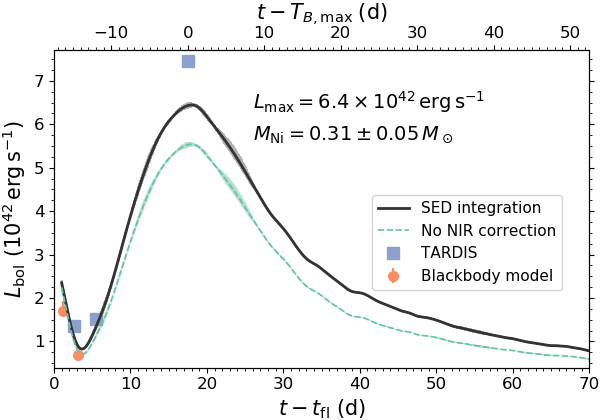

In [22]:
fig, ax = plt.subplots(figsize=(6,4.2))

ax.plot(t_grid, lum/1e42, '0.2', 
        zorder=10, label=r'SED integration', lw=2)
ax.errorbar(t_grid, lum/1e42, yerr=yunc/1e42, color='0.7')

ax.plot(t_grid, no_ir_lum/1e42, '#66c2a5', 
        zorder=10, label=r'No NIR correction', lw=1.2, ls='--')
ax.errorbar(t_grid, no_ir_lum/1e42, yerr=noirunc/1e42, color='#66c2a5', alpha=0.1)


# blackbody fits
sol_conv = const.L_sun.to('erg/s').value/1e42
ax.errorbar([1.24, 3.15], 
            np.array([4.459e+08, 1.822e+08])*sol_conv,
            yerr = sol_conv*np.array([[3.674e+07, 1.554e+07],[5.662e+07,2.262e+07]]),
            fmt = 'o', ms=7, label = 'Blackbody model', color='#fc8d62')

# TARDIS models
ax.plot(np.array([-14.9, -12.0, 0])-t_fl,
        sol_conv*10**np.array([8.55, 8.6, 9.29]), 
        's', ms=9, label='TARDIS', color='#8da0cb')

ax.legend(bbox_to_anchor=(.58, .22, 0, 0), fontsize=11)

ax.set_xlim(0,70)
ax.tick_params(right=True,which='both',labelsize=12)
ax.yaxis.set_minor_locator(MultipleLocator(0.25))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.set_ylim(0.4,7.7)

ax.set_ylabel(r'$L_\mathrm{bol}\,\,(10^{42}\,\mathrm{erg\,s}^{-1})$', fontsize=15)
ax.set_xlabel(r'$t - t_\mathrm{fl}$ (d)', fontsize=15)

ax.text(26, 6.35, r'$L_\mathrm{max} = 6.4 \times 10^{42}\,\mathrm{erg\,s}^{-1}$', fontsize=14)
ax.text(26, 5.65, r'$M_\mathrm{Ni} = 0.31 \pm 0.05\,M_\odot$', fontsize=14)

# set up time relative to T_Bmax
ax2 = ax.twiny()
ax2.set_xlabel(r"$t - T_{B,\mathrm{max}} \; (\mathrm{d})$", fontsize=15)
ax2.set_xlim(np.array(ax.get_xlim()) + t_fl)
ax2.tick_params(which='both', top=True, labelsize=12)
ax2.xaxis.set_minor_locator(MultipleLocator(1))


fig.subplots_adjust(top=0.88,right=0.982,left=0.09,bottom=0.125)
fig.savefig('../paper/figures/L_bolometric.pdf')

In [23]:
t_max = t_grid[np.argmax(lum)]
l_max = np.max(lum)
print(t_max, l_max, lum_unc[np.argmax(lum)])

18.05 6.444661938306183e+42 [6.39245639e+42 6.49441889e+42]


In [24]:
t_max = 18.1
nady = 6.45e43*np.exp(-t_max/8.8) + 1.45e43*np.exp(-t_max/111.3)
l_max/nady

0.3132934182025901

In [25]:
with open('Lbol.txt', 'w') as fw:
    for t, l, l_low, l_upp in zip(t_grid, lum, lum_unc[:,0], lum_unc[:,1]):
        print(t, l, l_low, l_upp, file=fw)

In [26]:
with open('L_no_nir.txt', 'w') as fw:
    for t, l, l_low, l_upp in zip(t_grid, no_ir_lum, no_ir_lum_unc[:,0], no_ir_lum_unc[:,1]):
        print(t, l, l_low, l_upp, file=fw)

In [27]:
with open('L_gri.txt', 'w') as fw:
    for t, l, l_low, l_upp in zip(t_grid, gri_lum, gri_lum_unc[:,0], gri_lum_unc[:,1]):
        print(t, l, l_low, l_upp, file=fw)

# $M_\mathrm{ej}$

In [28]:
t0 = 42.01

m_ej = 1.38 * (1/3/0.45) * (t0/36.8)**2
m_ej_unc = np.sqrt((.08/.45)**2 + 2*(180/3000)**2 + 2*(1/t0)**2)*m_ej

print("Mej = {:.4f} +/- {:.4f}".format(m_ej, m_ej_unc))

Mej = 1.3322 +/- 0.2662


In [29]:
t0_no_nir = 38.13

m_no_nir = 1.38 * (1/3/0.45) * (t0_no_nir/36.8)**2
m_no_nir_unc = np.sqrt((.08/.45)**2 + 2*(180/3000)**2 + 2*(1/t0_no_nir)**2)*m_no_nir

print("with no NIR correction, Mej = {:.4f} +/- {:.4f}".format(m_no_nir, m_no_nir_unc))

with no NIR correction, Mej = 1.0974 +/- 0.2200
